## Dataset Generation
We create random RTL Verilog modules (e.g., simple combinational, deep pipelines, high fan-in) with varying parameters. Each module is synthesized using Yosys to gather features like gate counts and combinational depth. We then combine the generated code, expected features, and extracted synthesis data into a JSON dataset, ready for machine learning or analysis.

In [18]:
import random
import os
import subprocess
import json
import re

def generate_random_verilog():
    """
    Randomly selects a design template and returns the module name, the Verilog code,
    and a dictionary with expected features.
    """
    template = random.choice(["simple_comb", "deep_pipeline", "high_fanin", "multi_clock"])
    if template == "simple_comb":
        return generate_simple_comb()
    elif template == "deep_pipeline":
        return generate_deep_pipeline()
    elif template == "high_fanin":
        return generate_high_fanin()
    elif template == "multi_clock":
        return generate_multi_clock()
    else:
        return generate_simple_comb()

def generate_simple_comb():
    """Generate a simple combinational circuit with only logic gates."""
    module_name = f"comb_{random.randint(1000, 9999)}"
    num_inputs = random.randint(2, 5)
    num_gates = random.randint(3, 8)
    inputs = [f"in{i}" for i in range(num_inputs)]
    output = "out"
    verilog_code = f"module {module_name}({', '.join(inputs)}, {output});\n"
    verilog_code += "  input " + ", ".join(inputs) + ";\n"
    verilog_code += "  output " + output + ";\n"
    # Create intermediate wires
    wires = [f"w{i}" for i in range(num_gates)]
    for w in wires:
        verilog_code += f"  wire {w};\n"
    # Chain of gates
    gate_type = random.choice(["and", "or", "xor", "nand", "nor"])
    verilog_code += f"  {gate_type} g0({wires[0]}, {random.choice(inputs)}, {random.choice(inputs)});\n"
    for i in range(1, num_gates):
        gate_type = random.choice(["and", "or", "xor", "nand", "nor"])
        verilog_code += f"  {gate_type} g{i}({wires[i]}, {wires[i-1]}, {random.choice(inputs)});\n"
    verilog_code += f"  assign {output} = {wires[-1]};\nendmodule\n"
    expected_features = {
        "template": "simple_comb",
        "num_inputs": num_inputs,
        "num_gates": num_gates,
        "expected_ff": 0
    }
    return module_name, verilog_code, expected_features

def generate_deep_pipeline():
    """Generate a deep pipelined circuit with multiple sequential stages."""
    module_name = f"pipe_{random.randint(1000, 9999)}"
    num_stages = random.randint(3, 7)
    num_inputs = random.randint(2, 4)
    inputs = [f"in{i}" for i in range(num_inputs)]
    output = "out"
    verilog_code = f"module {module_name}({', '.join(inputs)}, clk, reset, {output});\n"
    verilog_code += "  input clk, reset;\n"
    verilog_code += "  input " + ", ".join(inputs) + ";\n"
    verilog_code += "  output " + output + ";\n"
    # First combinational stage
    verilog_code += "  wire stage0;\n"
    gate_type = random.choice(["and", "or", "xor", "nand", "nor"])
    verilog_code += f"  {gate_type} g0(stage0, {random.choice(inputs)}, {random.choice(inputs)});\n"
    # Pipeline stages: each stage uses a flip-flop and a combinational gate
    for i in range(1, num_stages):
        verilog_code += f"  reg stage{i}_ff;\n"
        verilog_code += f"  always @(posedge clk or posedge reset) begin\n"
        verilog_code += f"    if (reset) stage{i}_ff <= 0;\n"
        if i == 1:
            verilog_code += f"    else stage{i}_ff <= stage0;\n"
        else:
            verilog_code += f"    else stage{i}_ff <= stage{i-1}_ff;\n"
        verilog_code += f"  end\n"
        verilog_code += f"  wire stage{i};\n"
        gate_type = random.choice(["and", "or", "xor", "nand", "nor"])
        verilog_code += f"  {gate_type} g{i}(stage{i}, stage{i}_ff, {random.choice(inputs)});\n"
    verilog_code += f"  assign {output} = stage{num_stages-1};\nendmodule\n"
    expected_features = {
        "template": "deep_pipeline",
        "num_inputs": num_inputs,
        "num_pipeline_stages": num_stages,
        "expected_ff": num_stages  # one flip-flop per stage (after first combinational)
    }
    return module_name, verilog_code, expected_features

def generate_high_fanin():
    """Generate a circuit with high fan-in using an OR tree."""
    module_name = f"fanin_{random.randint(1000, 9999)}"
    num_inputs = random.randint(8, 16)
    inputs = [f"in{i}" for i in range(num_inputs)]
    output = "out"
    verilog_code = f"module {module_name}({', '.join(inputs)}, {output});\n"
    verilog_code += "  input " + ", ".join(inputs) + ";\n"
    verilog_code += "  output " + output + ";\n"
    # Build an OR tree to combine many inputs
    current_level = inputs.copy()
    level = 0
    while len(current_level) > 1:
        next_level = []
        for i in range(0, len(current_level), 2):
            if i+1 < len(current_level):
                wire = f"w_{level}_{i//2}"
                verilog_code += f"  wire {wire};\n"
                verilog_code += f"  or g_{level}_{i//2}({wire}, {current_level[i]}, {current_level[i+1]});\n"
                next_level.append(wire)
            else:
                next_level.append(current_level[i])
        current_level = next_level
        level += 1
    verilog_code += f"  assign {output} = {current_level[0]};\nendmodule\n"
    expected_features = {
        "template": "high_fanin",
        "num_inputs": num_inputs,
        "expected_ff": 0,
        "or_tree_levels": level
    }
    return module_name, verilog_code, expected_features

def generate_multi_clock():
    """Generate a design with two clock domains and a clock domain crossing."""
    module_name = f"multiclk_{random.randint(1000, 9999)}"
    num_inputs = random.randint(2, 4)
    inputs = [f"in{i}" for i in range(num_inputs)]
    output = "out"
    verilog_code = f"module {module_name}({', '.join(inputs)}, clk1, clk2, reset, {output});\n"
    verilog_code += "  input clk1, clk2, reset;\n"
    verilog_code += "  input " + ", ".join(inputs) + ";\n"
    verilog_code += "  output " + output + ";\n"
    # Clock domain 1: combinational logic and flip-flop
    verilog_code += "  wire comb1;\n"
    gate_type = random.choice(["and", "or", "xor", "nand", "nor"])
    verilog_code += f"  {gate_type} g0(comb1, {random.choice(inputs)}, {random.choice(inputs)});\n"
    verilog_code += "  reg reg1;\n"
    verilog_code += "  always @(posedge clk1 or posedge reset) begin\n"
    verilog_code += "    if (reset) reg1 <= 0;\n"
    verilog_code += "    else reg1 <= comb1;\n"
    verilog_code += "  end\n"
    # Domain crossing: register the signal in the second clock domain
    verilog_code += "  reg cross_domain;\n"
    verilog_code += "  always @(posedge clk2 or posedge reset) begin\n"
    verilog_code += "    if (reset) cross_domain <= 0;\n"
    verilog_code += "    else cross_domain <= reg1;\n"
    verilog_code += "  end\n"
    verilog_code += f"  assign {output} = cross_domain;\nendmodule\n"
    expected_features = {
        "template": "multi_clock",
        "num_inputs": num_inputs,
        "expected_ff": 2,  # one FF in clk1 and one in clk2
        "clock_domains": 2
    }
    return module_name, verilog_code, expected_features

def write_verilog_to_file(module_name, verilog_code, path="verilog_files"):
    """Writes the generated Verilog code to a file."""
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, f"{module_name}.v")
    with open(file_path, "w") as f:
        f.write(verilog_code)
    return file_path

def synthesize_with_yosys(verilog_file):
    """
    Runs Yosys synthesis on the provided Verilog file.
    Uses a synthesis flow that omits aggressive optimizations.
    """
    module_name = os.path.splitext(os.path.basename(verilog_file))[0]
    yosys_script = f"""
    read_verilog {verilog_file}
    synth -top {module_name}
    stat
    """
    result = subprocess.run(["/opt/homebrew/bin/yosys"], input=yosys_script, text=True, capture_output=True)
    return result.stdout

def parse_synthesis_report(report):
    """
    Parses the Yosys synthesis report to extract:
      - Combinational depth
      - Total gate (cell) count
      - Flip-flop count
      - (Heuristic) fan_in and fan_out values
    Prints the full report for debugging and attempts several regex patterns.
    """
    print("Full Yosys Report:")
    print(report)

    depth = None
    gate_counts = {}
    ff_count = None

    # Try multiple regex patterns for combinational depth
    m = re.search(r"Combinational depth:\s*(\d+)", report)
    if not m:
        m = re.search(r"Comb\.? depth:\s*(\d+)", report)
    if not m:
        m = re.search(r"Depth:\s*(\d+)", report)
    if m:
        depth = int(m.group(1))
    else:
        print("Combinational depth not found in report")

    # Parsing for total cell count
    m = re.search(r"Number of cells:\s*(\d+)", report)
    if m:
        gate_counts["total"] = int(m.group(1))
    else:
        print("Number of cells not found in report")

    # Try multiple regex patterns for flip-flop count
    m = re.search(r"Number of FFs:\s*(\d+)", report)
    if not m:
        m = re.search(r"FFs:\s*(\d+)", report)
    if not m:
        m = re.search(r"Registers:\s*(\d+)", report)
    if m:
        ff_count = int(m.group(1))
    else:
        print("Flip-flop count not found in report")

    # Heuristic values for fan-in and fan-out (for illustration)
    fan_in = random.randint(1, 4)
    fan_out = random.randint(1, 4)

    return {
        "combinational_depth": depth,
        "gate_counts": gate_counts,
        "flip_flops": ff_count,
        "fan_in": fan_in,
        "fan_out": fan_out
    }

def main(num_samples=50, output_file="gogout.json"):
    """
    Generates a dataset of various RTL designs by:
      - Generating a random Verilog design.
      - Writing the Verilog to a file.
      - Running Yosys synthesis.
      - Parsing the synthesis report.
      - Saving the collected data into a JSON file.
    """
    dataset = []
    for i in range(num_samples):
        module_name, verilog_code, expected_features = generate_random_verilog()
        file_path = write_verilog_to_file(module_name, verilog_code)
        report = synthesize_with_yosys(file_path)
        extracted_features = parse_synthesis_report(report)
        entry = {
            "module": module_name,
            "template": expected_features.get("template"),
            "rtl_code": verilog_code,
            "expected_features": expected_features,
            "synthesis_report": report,
            "extracted_features": extracted_features
        }
        dataset.append(entry)
        print(f"Processed {module_name}")
    with open(output_file, "w") as f:
        json.dump(dataset, f, indent=4)
    print("Dataset generated successfully!")

if __name__ == "__main__":
    main()


Full Yosys Report:

 /----------------------------------------------------------------------------\
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |  Copyright (C) 2012 - 2025  Claire Xenia Wolf <claire@yosyshq.com>         |
 |  Distributed under an ISC-like license, type "license" to see terms        |
 \----------------------------------------------------------------------------/
 Yosys 0.50 (git sha1 b5170e1394f602c607e75bdbb1a2b637118f2086, clang++ 16.0.0 -fPIC -O3)

yosys> 

yosys>     read_verilog verilog_files/multiclk_6095.v

1. Executing Verilog-2005 frontend: verilog_files/multiclk_6095.v
Parsing Verilog input from `verilog_files/multiclk_6095.v' to AST representation.
Generating RTLIL representation for module `\multiclk_6095'.
Successfully finished Verilog frontend.

yosys>     synth -top multiclk_6095

2. Executing SYNTH pass.

2.1. Executing HIERARCHY pass (managing design hierarchy).

2.1.1. Analyzing design hierarchy..
Top module:  \mu

## Data Preprocessing and Feature Engineering

Drawing on **theoretical knowledge** of RTL design, we **derive new features** (e.g., ratios, composite metrics) from the existing dataset, **enhancing** each design’s representation and **capturing** deeper insights into complexity.

In [45]:
import json
import pandas as pd
import numpy as np

# Load the raw dataset
with open("final_dataset.json", "r") as f:
    raw_data = json.load(f)

# Convert raw data into a DataFrame
df = pd.DataFrame(raw_data)

# Flatten nested dictionaries for expected and extracted features
expected_df = pd.json_normalize(df["expected_features"])
extracted_df = pd.json_normalize(df["extracted_features"])

# Merge these with module-level info (module, template, rtl_code)
data = pd.concat([df[['module', 'template', 'rtl_code']], expected_df, extracted_df], axis=1)

# Rename columns for clarity
if 'gate_counts.total' in data.columns:
    data = data.rename(columns={'gate_counts.total': 'total_gate_count'})

# ------------------------------
# Advanced Feature Engineering
# ------------------------------

# 1. Fan-In / Fan-Out Ratio: indicates load and complexity.
data['fan_in_out_ratio'] = data.apply(
    lambda row: row['fan_in'] / row['fan_out'] if row['fan_out'] != 0 else np.nan, axis=1
)

# 2. Logic Complexity Ratio: total gate count divided by number of flip-flops.
data['logic_complexity_ratio'] = data.apply(
    lambda row: row['total_gate_count'] / row['flip_flops']
    if (row['flip_flops'] and row['flip_flops'] > 0) else row['total_gate_count'], axis=1
)

# 3. Pipeline Stage Count: for deep_pipeline designs, use expected pipeline stages; otherwise, 1.
data['pipeline_stage_count'] = data.apply(
    lambda row: row['num_pipeline_stages'] if 'num_pipeline_stages' in row and not pd.isna(row['num_pipeline_stages']) else 1,
    axis=1
)

# 4. Estimated Delay:
#    Used extracted combinational_depth if available, otherwise fallback to expected_comb_depth.
#    Assume DELAY_PER_GATE = 1.0 unit and DELAY_PER_FF = 0.5 unit per pipeline stage.
DELAY_PER_GATE = 1.0
DELAY_PER_FF = 0.5
data['used_comb_depth'] = data.apply(
    lambda row: row['combinational_depth'] if not pd.isna(row['combinational_depth'])
                else row.get('expected_comb_depth', 0),
    axis=1
)
data['estimated_delay'] = data['used_comb_depth'] * DELAY_PER_GATE + data['pipeline_stage_count'] * DELAY_PER_FF

# 5. Composite Metrics:
#    a) Flip-Flop to Gate Ratio: ratio of flip-flops to total gate count.
data['ff_to_gate_ratio'] = data.apply(
    lambda row: row['flip_flops'] / row['total_gate_count'] if row['total_gate_count'] != 0 else np.nan, axis=1
)

#    b) Delay-to-Fanout Ratio: estimated delay normalized by fan-out.
data['delay_to_fanout_ratio'] = data.apply(
    lambda row: row['estimated_delay'] / row['fan_out'] if row['fan_out'] != 0 else np.nan, axis=1
)

#    c) Fan-In and Fan-Out Product: as a measure of interconnect complexity.
data['fan_in_fan_out_product'] = data['fan_in'] * data['fan_out']

#    d) Weighted Complexity: a composite metric that multiplies estimated delay by logic complexity ratio.
data['weighted_complexity'] = data['estimated_delay'] * data['logic_complexity_ratio']

# ------------------------------
# Preview and Save the Engineered Features
# ------------------------------
feature_columns = [
    'module', 'template', 'num_inputs', 'num_gates', 'expected_ff', 'expected_comb_depth',
    'combinational_depth', 'flip_flops', 'total_gate_count', 'fan_in', 'fan_out',
    'fan_in_out_ratio', 'logic_complexity_ratio', 'pipeline_stage_count', 'estimated_delay',
    'ff_to_gate_ratio', 'delay_to_fanout_ratio', 'fan_in_fan_out_product', 'weighted_complexity'
]

print("Advanced Engineered Features Preview:")
print(data[feature_columns].head())

# Save the engineered features to a CSV file for model training
data.to_csv("advanced_engineered_features.csv", index=False)
print("Advanced engineered features saved to advanced_engineered_features.csv")


Advanced Engineered Features Preview:
          module       template       template  num_inputs  num_gates  \
0      comb_3530    simple_comb    simple_comb           5        4.0   
1      pipe_3380  deep_pipeline  deep_pipeline           4        NaN   
2  multiclk_8093    multi_clock    multi_clock           2        NaN   
3     fanin_8225     high_fanin     high_fanin          12        NaN   
4  multiclk_6608    multi_clock    multi_clock           3        NaN   

   expected_ff  expected_comb_depth  combinational_depth  flip_flops  \
0            0                    4                    4           0   
1            5                    5                    5           5   
2            2                    1                    1           2   
3            0                    4                    4           0   
4            2                    1                    1           2   

   total_gate_count  fan_in  fan_out  fan_in_out_ratio  \
0                 4       3     

## Model Training and Evaluation

We **train** multiple regression models (e.g., Random Forest, Gradient Boosting, Decision Tree) via **scikit-learn**, **tune** hyperparameters with cross-validation, and **evaluate** them using metrics like R² and MSE. This process helps **identify** the best-performing model and **quantify** its accuracy on unseen data.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Model Performance Summary:
               Model                                        Best Params  \
0      Random Forest  {'rf__bootstrap': False, 'rf__max_depth': None...   
1  Gradient Boosting  {'gb__learning_rate': 0.1, 'gb__max_depth': 5,...   
2      Decision Tree  {'dt__max_depth': None, 'dt__min_samples_leaf'...   

   Test MSE   Test R²  
0  1.261000  0.723465  
1  0.617811  0.864515  
2  0.200000  0.956140  


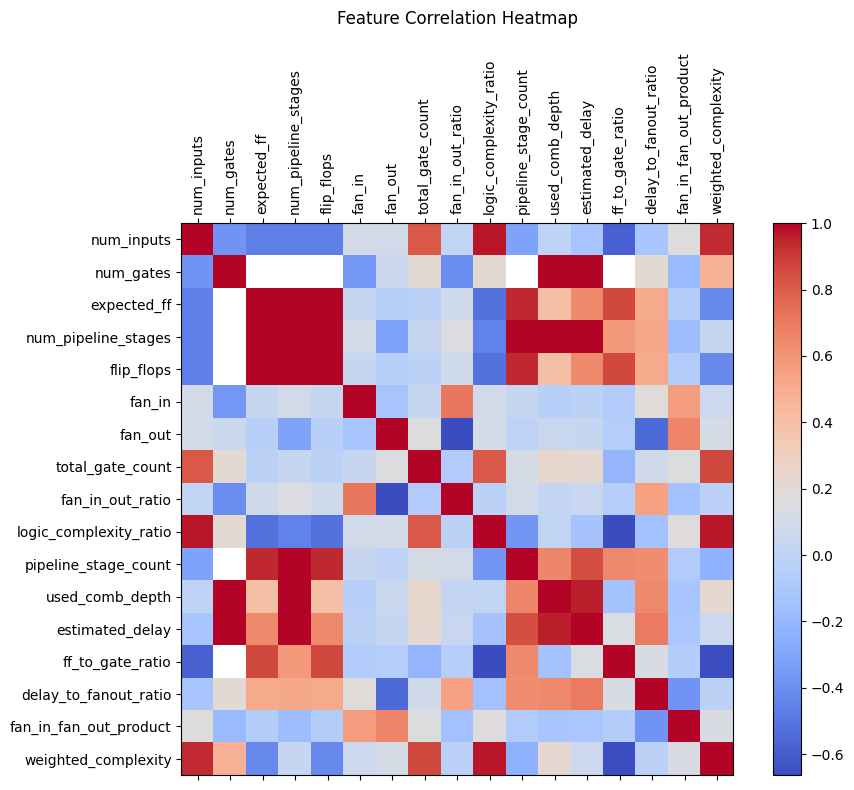

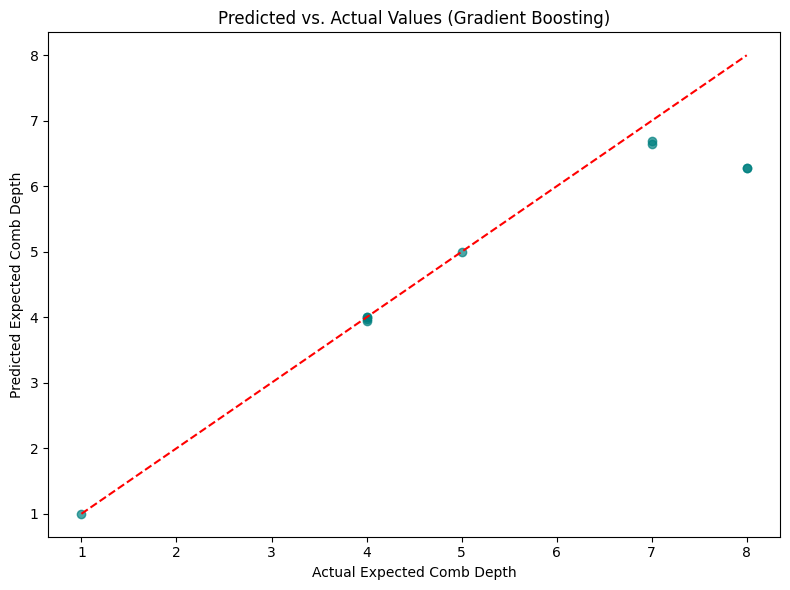

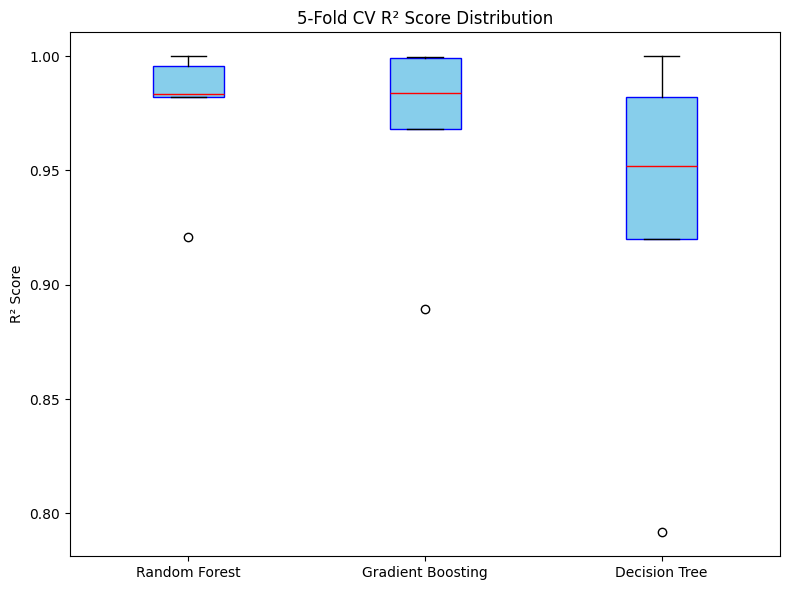

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

# ------------------------------
# Load Data and Define Target/Features
# ------------------------------
data = pd.read_csv("advanced_engineered_features.csv")
target_column = 'expected_comb_depth'
y = data[target_column]

# Use only numeric features (dropping removed or leakage columns, e.g. 'combinational_depth')
X = data.select_dtypes(include=[np.number]).drop(columns=[target_column, 'combinational_depth'], errors='ignore')

# ------------------------------
# Split Data into Train/Test
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# Define Pipelines for Each Model
# ------------------------------
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

gb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingRegressor(random_state=42))
])

dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('dt', DecisionTreeRegressor(random_state=42))
])

# ------------------------------
# Hyperparameter Tuning: GridSearchCV Setup
# ------------------------------
param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__bootstrap': [True, False]
}

param_grid_gb = {
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.01, 0.1],
    'gb__max_depth': [3, 5],
    'gb__min_samples_split': [2, 5],
    'gb__min_samples_leaf': [1, 2]
}

param_grid_dt = {
    'dt__max_depth': [None, 10, 20],
    'dt__min_samples_split': [2, 5],
    'dt__min_samples_leaf': [1, 2]
}

# ------------------------------
# Train and Evaluate Each Model
# ------------------------------

# 1. Random Forest
rf_grid = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='r2', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
rf_preds = best_rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

# 2. Gradient Boosting
gb_grid = GridSearchCV(gb_pipeline, param_grid_gb, cv=5, scoring='r2', n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
gb_preds = best_gb.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_preds)
gb_r2 = r2_score(y_test, gb_preds)

# 3. Decision Tree
dt_grid = GridSearchCV(dt_pipeline, param_grid_dt, cv=5, scoring='r2', n_jobs=-1, verbose=1)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
dt_preds = best_dt.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_preds)
dt_r2 = r2_score(y_test, dt_preds)

# ------------------------------
# Create Summary Table
# ------------------------------
results = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Decision Tree'],
    'Best Params': [
        rf_grid.best_params_,
        gb_grid.best_params_,
        dt_grid.best_params_
    ],
    'Test MSE': [rf_mse, gb_mse, dt_mse],
    'Test R²': [rf_r2, gb_r2, dt_r2]
}

results_df = pd.DataFrame(results)
print("Model Performance Summary:")
print(results_df)
results_df.to_csv("model_performance_summary.csv", index=False)

# ------------------------------
# Feature Correlation Heatmap using matplotlib only
# ------------------------------
# Created a temporary copy of X without 'clock_domain' or 'or_tree_level' for better depiction
X_for_corr = X.drop(columns=['clock_domains', 'or_tree_levels'], errors='ignore')

corr = X_for_corr.corr()
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap='coolwarm')
fig.colorbar(cax)

# Set tick labels
ticks = np.arange(0, len(corr.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
plt.title("Feature Correlation Heatmap", pad=20)
plt.tight_layout()
plt.savefig("feature_correlation_heatmap.png")
plt.show()

# ------------------------------
# Scatter Plot: Predicted vs. Actual for Best Model (Gradient Boosting)
# ------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, gb_preds, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Expected Comb Depth")
plt.ylabel("Predicted Expected Comb Depth")
plt.title("Predicted vs. Actual Values (Gradient Boosting)")
plt.tight_layout()
plt.savefig("predicted_vs_actual.png")
plt.show()

# ------------------------------
# Cross-Validation Score Distribution Boxplot using matplotlib
# ------------------------------
cv_scores_rf = cross_val_score(best_rf, X, y, cv=5, scoring='r2', n_jobs=-1)
cv_scores_gb = cross_val_score(best_gb, X, y, cv=5, scoring='r2', n_jobs=-1)
cv_scores_dt = cross_val_score(best_dt, X, y, cv=5, scoring='r2', n_jobs=-1)

fig, ax = plt.subplots(figsize=(8,6))
data_to_plot = [cv_scores_rf, cv_scores_gb, cv_scores_dt]
ax.boxplot(data_to_plot, patch_artist=True,
           labels=["Random Forest", "Gradient Boosting", "Decision Tree"],
           boxprops=dict(facecolor="skyblue", color="blue"),
           medianprops=dict(color="red"))
ax.set_ylabel("R² Score")
ax.set_title("5-Fold CV R² Score Distribution")
plt.tight_layout()
plt.savefig("cv_score_distribution.png")
plt.show()
